## STAT 542 - Project 2 : Question 2 Feature Engineering
##### Neeraj Wagh (nwagh2), Sunny Katiyar (sunnyk2), Pradnyesh Joshi (pvjoshi2)

## Image import

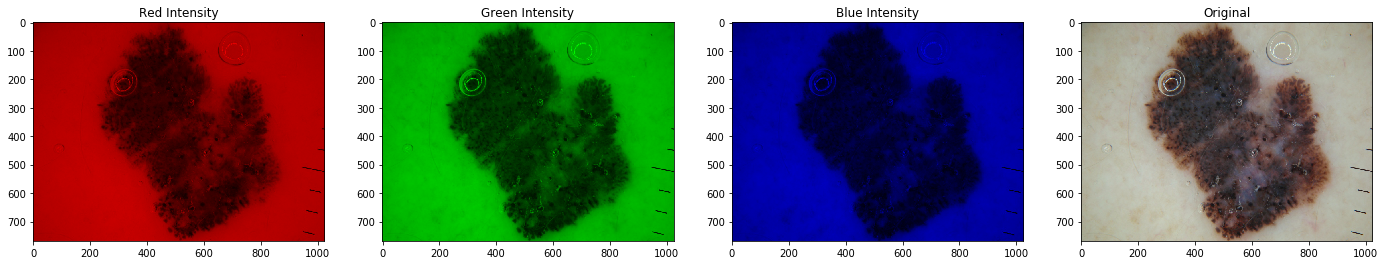

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage import data, io, filters
import os

def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

# filepath = os.path.abspath("./data/benign/ISIC_0000232.jpg")
filepath = os.path.abspath("./data/malignant/ISIC_0010416.jpg")
# filepath = os.path.abspath("./data/malignant/ISIC_0033192.jpg")
# filepath = os.path.abspath("./data/benign/ISIC_0034267.jpg")


# filepath = os.path.abspath("./data/benign/ISIC_0000232.jpg")
image = data.load(filepath)

red, green, blue = image.copy(), image.copy(), image.copy()

red[:,:,(1,2)] = 0
green[:,:,(0,2)] = 0
blue[:,:,(0,1)] = 0

show_images(images=[red, green, blue, image], titles=['Red Intensity', 'Green Intensity', 'Blue Intensity', 'Original'])


## [PREPROCESS] Binarize + Cropping Image

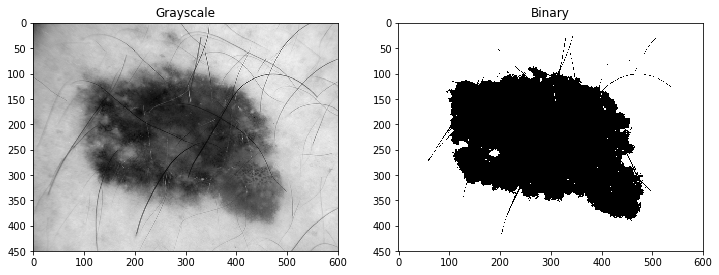

In [20]:
from skimage import data
from skimage.color import rgb2gray
from skimage import filters


# filepath = os.path.abspath("./data/benign/ISIC_0033398.jpg")
# filepath = os.path.abspath("./data/malignant/ISIC_0026993.jpg")
filepath = os.path.abspath("./data/malignant/ISIC_0033192.jpg")

image = data.load(filepath)
image_gs = rgb2gray(image)

binary_image = np.where(image_gs > filters.threshold_li(image_gs),1.0,0.0)

# crop_v = 200
# crop_h = 50
crop_v = round(0.10 * binary_image.shape[1])
crop_h = round(0.05 * binary_image.shape[0])

binary_image[ :, :crop_v ] = True
binary_image[ :, -crop_v: ] = True

binary_image[ :crop_h, :] = True
binary_image[ -crop_h:, :] = True

show_images(images=[image_gs, binary_image],
            titles=["Grayscale","Binary"])

## [PREPROCESS] Isolated Mole / Remove small objects

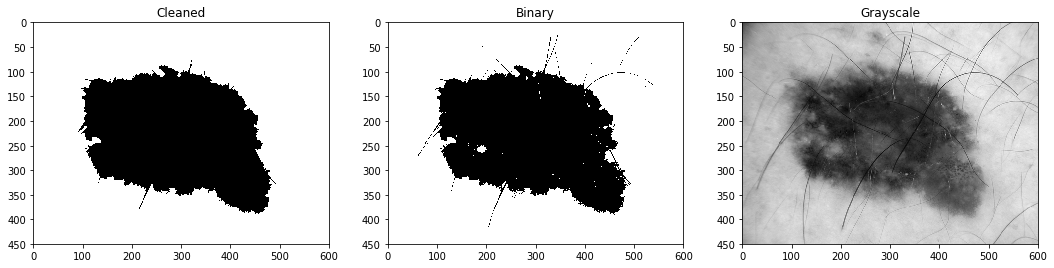

In [21]:
from skimage import io, morphology

test = binary_image > 0
cleaned = morphology.remove_small_objects(test, min_size=3000, connectivity=0.1)
cleaned = morphology.remove_small_holes(cleaned, area_threshold=500)

show_images(images=[cleaned, binary_image, image_gs],
            titles=["Cleaned","Binary", "Grayscale"])

## [FEATURE] Circularity of mole / Irregularity of mole border

In [22]:
# https://www.mathworks.com/matlabcentral/answers/85363-which-one-is-best-for-calculating-circularity
# circularity = (Perimeter .^ 2) ./ (4 * pi * area);
# the circularity of a circle is 1 and the higher it goes, the less circular it it. ??

from skimage.measure import perimeter

total_perimeter = perimeter(cleaned, neighbourhood=8)
total_perimeter

total_black_pixels = np.sum(cleaned == False)
total_black_pixels

total_pixels = cleaned.shape[0] * cleaned.shape[1]
total_pixels

circularity = (total_perimeter ** 2) / (4 * np.pi * total_black_pixels)
circularity

23.135638541015908

## [FEATURE] Asymmetry

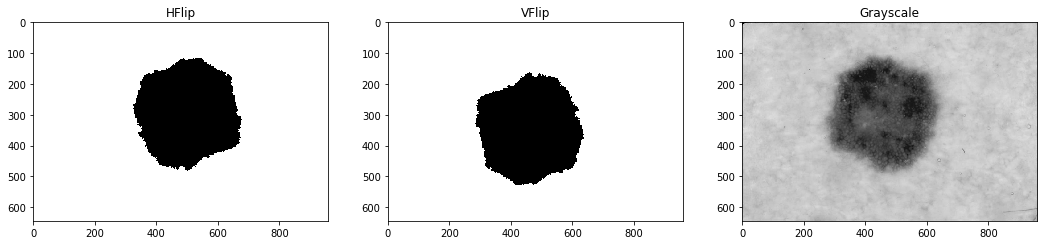

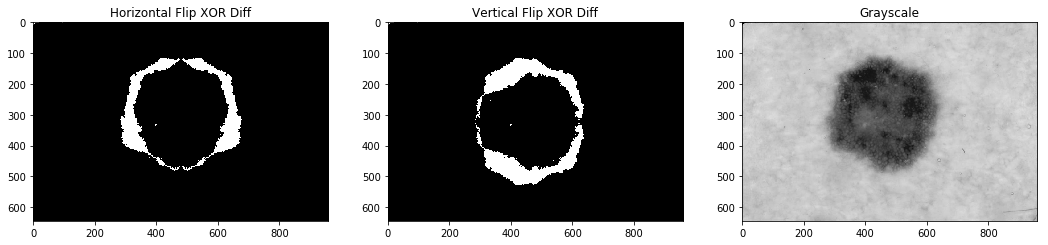

0.1094250645994832

In [23]:
# one logic - flip the image horizontally, combine the mirror images, compare resultant image with the original and count how many pixels differ in intensity,
# the more pixels that differ, the more asymmetric the original image is. Maybe repeat vertically.

import numpy as np

# filepath = os.path.abspath("./data/malignant/ISIC_0010416.jpg")
filepath = os.path.abspath("./data/benign/ISIC_0000232.jpg")
# filepath = os.path.abspath("./data/malignant/ISIC_0033192.jpg")
# filepath = os.path.abspath("./data/benign/ISIC_0034267.jpg")


image = data.load(filepath)
image_gs = rgb2gray(image)

binary_image = np.where(image_gs > filters.threshold_li(image_gs),1.0,0.0)

test = binary_image > 0
cleaned = morphology.remove_small_objects(test, min_size=300, connectivity=0.1)
cleaned = morphology.remove_small_holes(cleaned, area_threshold=400)

mole_vflip = np.flip(cleaned, axis=0)
mole_hflip = np.flip(cleaned, axis=1)

show_images(images=[mole_hflip, mole_vflip, image_gs],
            titles=["HFlip","VFlip", "Grayscale"])

# get number of indices that are different from each other in original and hflip image
difference_hflip = np.logical_xor(mole_hflip, binary_image)
difference_vflip = np.logical_xor(mole_vflip, binary_image)

asymmetry_score = (np.sum(difference_hflip == True) + np.sum(difference_vflip == True)) / image_gs.flatten().shape[0]
asymmetry_score

show_images(images=[difference_hflip, difference_vflip, image_gs],
            titles=["Horizontal Flip XOR Diff","Vertical Flip XOR Diff", "Grayscale"])

asymmetry_score

## [FEATURE] Color Distribution within the mole

0.3476053873697917

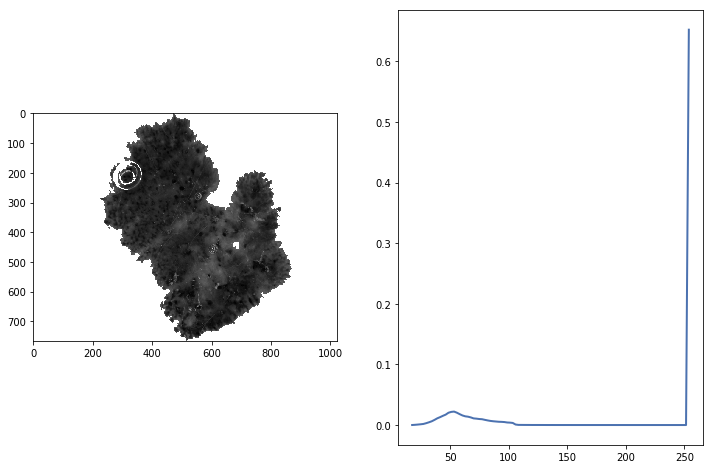

In [31]:
from skimage.exposure import histogram

filepath = os.path.abspath("./data/malignant/ISIC_0010416.jpg")
# filepath = os.path.abspath("./data/benign/ISIC_0000210.jpg")
image = data.load(filepath)
image_gs = rgb2gray(image)

binary_image = np.where(image_gs > filters.threshold_li(image_gs),1.0,0.0)
test = binary_image > 0
cleaned = morphology.remove_small_objects(test, min_size=300, connectivity=0.1)
cleaned = morphology.remove_small_holes(cleaned, area_threshold=400)

mole_isolated  = image_gs.copy()
mole_isolated[cleaned] = 1

hist, hist_centers = histogram(mole_isolated, nbins=100)
hist = hist / np.sum(hist)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(mole_isolated, cmap=plt.cm.gray)
axes[1].plot(hist_centers * 255, hist, lw=2)

# sum up all hist values uptil the 200 color index
colors = hist_centers * 255
index_200 = len(colors[(colors <= 200.0)])
cumulative_hist_sum = np.sum(hist[:index_200])
cumulative_hist_sum

## [FEATURE] Diameter of mole

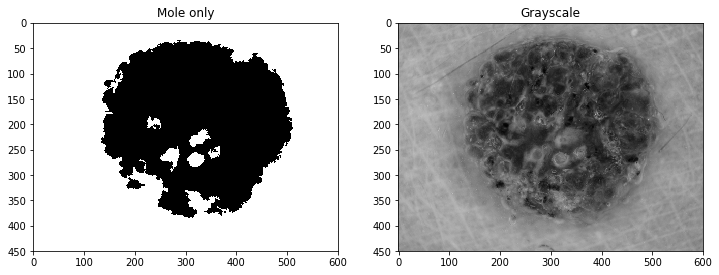

359.0

In [30]:
# filepath = os.path.abspath("./data/malignant/ISIC_0025835.jpg")
# filepath = os.path.abspath("./data/benign/ISIC_0000104.jpg")
filepath = os.path.abspath("./data/malignant/ISIC_0033061.jpg")

image = data.load(filepath)
image_gs = rgb2gray(image)

binary_image = np.where(image_gs > filters.threshold_li(image_gs),1.0,0.0)
test = binary_image > 0
cleaned = morphology.remove_small_objects(test, min_size=300, connectivity=0.1)
cleaned = morphology.remove_small_holes(cleaned, area_threshold=400)

show_images(images=[cleaned, image_gs],
            titles=["Mole only", "Grayscale"])

# scan image horizontally for max range of color=0 activation
hscan_1 = np.sum(binary_image, axis=0)
hscan_0 = binary_image.shape[0] - hscan_1
hscan_max = max(hscan_0)

# scan image vertically for max range of color=0 activation
vscan_1 = np.sum(binary_image, axis=1)
vscan_0 = binary_image.shape[1] - vscan_1
vscan_max = max(vscan_0)

# take the max of the two scans as the diameter of mole
diameter = max(hscan_max, vscan_max)
diameter

## Feature generator functions for entire dataset

In [ ]:
import glob
from skimage import data, io, filters
import os
import pandas as pd
from skimage import io, morphology
from skimage.color import rgb2gray
import numpy as np
from skimage.exposure import histogram
from skimage.measure import perimeter

# functions to generate features for each image

def get_asymmetry_score(image, image_gs, image_bin, image_clean):
    # one logic - flip the image horizontally, combine the mirror images, compare resultant image with the original and count how many pixels differ in intensity,
    # the more pixels that differ, the more asymmetric the original image is. Maybe repeat vertically.

    mole_vflip = np.flip(image_clean, axis=0)
    mole_hflip = np.flip(image_clean, axis=1)
    
    # get number of indices that are different from each other in original and hflip image
    difference_hflip = np.logical_xor(mole_hflip, image_bin)
    difference_vflip = np.logical_xor(mole_vflip, image_bin)

    asymmetry_score = (np.sum(difference_hflip == True) + np.sum(difference_vflip == True)) / image_gs.flatten().shape[0]
    return asymmetry_score

def get_diameter(image, image_gs, image_bin, image_clean):
    # scan image horizontally for max range of color=0 activation
    hscan_1 = np.sum(image_bin, axis=0)
    hscan_0 = image_bin.shape[0] - hscan_1
    hscan_max = max(hscan_0)

    # scan image vertically for max range of color=0 activation
    vscan_1 = np.sum(image_bin, axis=1)
    vscan_0 = image_bin.shape[1] - vscan_1
    vscan_max = max(vscan_0)

    diameter = max(hscan_max, vscan_max)
    return diameter

def get_color_variation(image, image_gs, image_bin, image_clean):
    mole_isolated  = image_gs.copy()
    mole_isolated[image_clean] = 1

    hist, hist_centers = histogram(mole_isolated, nbins=100)
    hist = hist / np.sum(hist)
    
    # sum up all hist values uptil the 200 color index
    colors = hist_centers * 255
    index_window = len(colors[(colors <= 200.0)])
    cumulative_hist_sum = np.sum(hist[:index_window])
    cumulative_hist_sum

    return cumulative_hist_sum

def get_circularity(image, image_gs, image_bin, image_clean):
    # https://www.mathworks.com/matlabcentral/answers/85363-which-one-is-best-for-calculating-circularity
    # circularity = (Perimeter .^ 2) ./ (4 * pi * area);
    # the circularity of a circle is 1 and the higher it goes, the less circular it it.    
    
    total_perimeter = perimeter(image_clean, neighbourhood=8)
    total_black_pixels = np.sum(image_clean == False)
    circularity = (total_perimeter ** 2) / (4 * np.pi * total_black_pixels)
    return circularity

def get_median(image, image_gs, image_bin, image_clean):
    red, blue, green = image.copy(), image.copy(), image.copy()
    red[:,:,(1,2)] = 0
    blue[:,:,(0,1)] = 0
    green[:,:,(0,2)] = 0

    mole_isolated  = red.copy()
    mole_isolated[image_clean == 1] = 255
    red_channel = mole_isolated[:,:,0]
    median_red = round(np.median(red_channel[image_clean != 1]), 3)

    mole_isolated  = green.copy()
    mole_isolated[image_clean == 1] = 255
    green_channel = mole_isolated[:,:,1]
    median_green = round(np.median(green_channel[image_clean != 1]), 3)

    mole_isolated  = blue.copy()
    mole_isolated[image_clean == 1] = 255
    blue_channel = mole_isolated[:,:,2]
    median_blue = round(np.median(blue_channel[image_clean != 1]), 3)

    return ((median_red, median_green, median_blue))


# create train and test sets
# folder = "benign"
folder = "malignant"
version = "v5"
img_list = glob.glob("data/" + folder + "/*.jpg", recursive=False)

csv_rows = [ ]
for img in img_list:

    # open image
    filepath = os.path.abspath(img)
    print(filepath)
    image = data.load(filepath)
    image_gs = rgb2gray(image)
    
    # add common preprocessing steps for all features here
    image_bin = np.where(image_gs > filters.threshold_li(image_gs),1.0,0.0)

    # crop_v = 200
    # crop_h = 50
    crop_v = round(0.10 * image_bin.shape[1])
    crop_h = round(0.05 * image_bin.shape[0])

    image_bin[ :, :crop_v ] = True
    image_bin[ :, -crop_v: ] = True

    image_bin[ :crop_h, :] = True
    image_bin[ -crop_h:, :] = True

    test = image_bin > 0
#     image_clean = morphology.remove_small_objects(test, min_size=3000, connectivity=0.001)
#     image_clean = morphology.remove_small_holes(image_clean, area_threshold=400)
    image_clean = morphology.remove_small_objects(test, min_size=6000, connectivity=0.1)
    image_clean = morphology.remove_small_holes(image_clean, area_threshold=5000)

    # downsample, resize, scale, crop, color normalization, binarize, whatever

    csv_row = { }
    csv_row["file_name"] = img.split("\\")[-1]
    csv_row["asymmetry_score"] = round(get_asymmetry_score(image, image_gs, image_bin, image_clean), 3)
    csv_row["diameter"] = round(get_diameter(image, image_gs, image_bin, image_clean), 3)
    csv_row["color_variation"] = round(get_color_variation(image, image_gs, image_bin, image_clean), 3)
    csv_row["circularity"] =  round(get_circularity(image, image_gs, image_bin, image_clean), 3)
    csv_row["median_red"], csv_row["median_green"], csv_row["median_blue"] = get_median(image, image_gs, image_bin, image_clean) 
#     csv_row["median_red"] = round(get_median(image, image_gs, image_bin, image_clean, "red"), 3)
#     csv_row["median_green"] = round(get_median(image, image_gs, image_bin, image_clean, "green"), 3)
#     csv_row["median_blue"] = round(get_median(image, image_gs, image_bin, image_clean, "blue"), 3)
    csv_rows.append(csv_row)

    
df = pd.DataFrame(csv_rows, columns = ["file_name", "asymmetry_score", "diameter", 
                                       "color_variation", "circularity",
                                      "median_red", "median_green", "median_blue"])
df.to_csv(folder + "_" + version + ".csv", index=False)

print(folder + "_" + version + ".csv generated!")

## Appendix (Exploratory Analysis)

## [PREPROCESS] Histogram Equalization

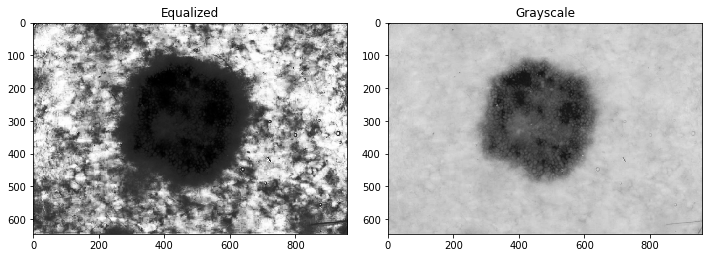

In [25]:
from skimage.exposure import equalize_hist

filepath = os.path.abspath("./data/benign/ISIC_0000232.jpg")
image = data.load(filepath)
image_gs = rgb2gray(image)

equalized_image = equalize_hist(image_gs)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes.ravel()

ax[0].imshow(equalized_image, cmap=plt.cm.gray)
ax[0].set_title("Equalized")
ax[1].imshow(image_gs, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

## [PREPROCESS] Find contours

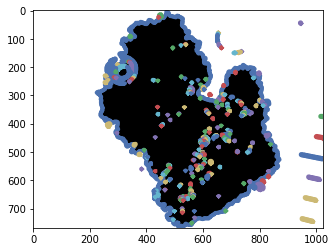

In [33]:
from skimage import measure

contours = measure.find_contours(binary_image, 0.9)

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.imshow(binary_image, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=4)

plt.show()

## [VISUALIZATION] Check histogram of features per label

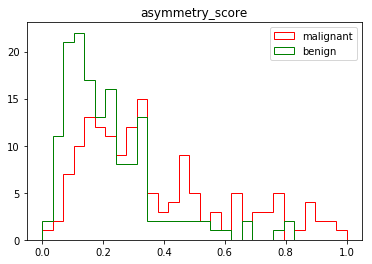

In [27]:
import numpy as np
import pandas as pd
df_benign = pd.read_csv("benign_test.csv")
df_malignant = pd.read_csv("malignant_test.csv")

check_feature = "asymmetry_score"
# check_feature = "diameter"
# check_feature = "color_variation"
# check_feature = "circularity"
# check_feature = "median_red"
# check_feature = "median_blue"
# check_feature = "median_green"

bins = np.linspace(0, 1, 30)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

plt.hist([df_benign[check_feature], df_malignant[check_feature]], bins, 
         label=['benign', 'malignant'], histtype="step", color=["green", "red"])
plt.legend(loc='upper right')
plt.title(check_feature)
plt.show()